In [1]:
#Steven Zajac-Descôteaux

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#pip install gensim

In [29]:
import pandas as pd
import scipy as sc
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score,fowlkes_mallows_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
import sys
### Gensim is outside the anaconda distribution ###
### uncomment to install Gensim ###
#!{sys.executable} -m pip install gensim
import gensim
import gensim.downloader as model_api

# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [4]:
COUNTRY_CODE = {'USA': 'us','UK': 'gb','Canada':'ca','Australia': 'au'}
APP_ID = {'Candy Crush': '553834731','Tinder': '547702041','Facebook': '284882215','Twitter': '333903271'}
PAGE_NUMBER = 1

REVIEW_LIST = []

df = pd.DataFrame(columns = ['Country','App','Review','Rating'])

for app, app_id in APP_ID.items():
    for country, c_id in COUNTRY_CODE.items():
        for page in range(1,11): #10 page limit with API 
            r = requests.get(
                f'https://itunes.apple.com/{c_id}/rss/customerreviews/id={app_id}/page={page}/sortby=mostrecent/json'
            )
                
            cont = json.loads(r.content)
            c = cont['feed']['entry']
            PAGE_NUMBER += 1
            for i in range(0,len(c)):
                review = pd.DataFrame({'App':app,'Country': country, 'Rating': [c[i]['im:rating']['label']], 
                                       'Review': [c[i]['content']['label']]})
                REVIEW_LIST.append(review)

df = pd.concat([*REVIEW_LIST,df],ignore_index=True)
df.Rating = pd.to_numeric(df.Rating) #Change rating value to numeric. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   App      8000 non-null   object
 1   Country  8000 non-null   object
 2   Rating   8000 non-null   int64 
 3   Review   8000 non-null   object
dtypes: int64(1), object(3)
memory usage: 250.1+ KB


In [26]:
#1.1
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['Review'])
wordLabels = vectorizer.get_feature_names()

pd.DataFrame(data=X.toarray(),columns=wordLabels).head()

,00,000,000km,10,100,1000,10000,1000km,1000s,1000x,...,𝚙𝚕𝚣,𝚛𝚎𝚊𝚕,𝚜𝚊𝚢𝚜,𝚜𝚘,𝚝𝚢𝚙𝚎,𝚠𝚊𝚜,𝚠𝚑𝚎𝚗,𝚠𝚑𝚢,𝚠𝚛𝚒𝚝𝚎,𝚢𝚘𝚞𝚛
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
COMPRESSED_SIZE = 200

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['Rating'].values
df['bag_o_words'] = pred
print('OLS R^2: ',r2_score(df['Rating'],pred))

OLS R^2:  0.2686088526996401


In [7]:
import sklearn.feature_extraction.text as text


tf = text.TfidfVectorizer()
X = tf.fit_transform(df['Review'])

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['Rating'].values
df['tf_idf'] = pred
print("OLS R^2: ", r2_score(df['Rating'], pred))

OLS R^2:  0.4294921056195792


In [52]:
tf = text.TfidfVectorizer()
X = tf.fit_transform(df['Review'])
X

<8000x12090 sparse matrix of type '<class 'numpy.float64'>'
	with 212469 stored elements in Compressed Sparse Row format>

In [53]:
pca = PCA(n_components=200)
X = pca.fit(X.todense().T).components_.T

In [54]:
k_cluster = KMeans(n_clusters=5)
k_cluster.fit(X)
preds = k_cluster.predict(X)
fowlkes_mallows_score(df.Rating,preds)

0.5990046799350025

In [8]:
#1.2

In [37]:
word_vectors = model_api.load("glove-wiki-gigaword-50")

In [39]:
import re

replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = df.Review.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,623,624,625,626,627,628,629,630,631,632
0,game,tells,you,every,move,to,make,no,challenge,None,...,None,None,None,None,None,None,None,None,None,None
1,i,have,a,person,that,has,asked,for,send,a,...,None,None,None,None,None,None,None,None,None,None
2,wow,i,am,not,a,happy,camper,had,to,delete,...,None,None,None,None,None,None,None,None,None,None
3,yes,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,game,is,fun,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,when,twitter,starts,being,“social”,media,and,not,the,doctor,...,None,None,None,None,None,None,None,None,None,None
7996,gosh,it’s,a,worry,to,be,censored,by,a,politically,...,None,None,None,None,None,None,None,None,None,None
7997,i,just,created,an,account,and,tweet,one,tweet,and,...,None,None,None,None,None,None,None,None,None,None
7998,twitter,keeps,blocking,conservative,messages,corrupt,app,fakenews,@jackdorkey,None,...,None,None,None,None,None,None,None,None,None,None


In [40]:
def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)
def map_vectors(row):
    try:
        res=row.loc[row.notna()].apply(soft_get)
        if len(res) >=1:
            return np.sum(res)
        else:
            return np.zeros(word_vectors.vector_size)
        # return np.sum(
        #     row.loc[row.notna()].apply(soft_get)
        # )
    except:
        return np.zeros(word_vectors.vector_size)
emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())
emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.296888,1.323863,0.891276,0.616632,4.564095,-0.200240,-3.817810,1.027826,-1.866773,0.747027,...,-0.395754,0.373684,-1.290064,2.457930,-0.418926,1.742496,0.733577,0.913661,0.635003,3.244640
1,62.139844,22.681087,8.450758,-35.329279,77.383746,9.344640,-75.629413,3.537233,-35.779060,-1.981450,...,-16.899322,21.925725,6.395319,44.307550,-10.981097,9.984151,-27.516183,-8.245311,-21.258837,18.082209
2,22.494572,8.959408,10.442123,-13.803926,30.251493,-2.726088,-37.566628,-0.673564,-11.616994,0.308978,...,-4.917016,-3.000140,-6.073211,12.645754,-5.842482,10.550914,-3.568150,-8.355165,0.750101,6.734367
3,-0.387960,0.204220,0.317330,-0.419850,0.474060,0.175530,-0.194100,-0.125940,-0.719530,0.442250,...,0.093074,0.057111,-0.154130,0.092241,-0.314470,0.427960,-0.524730,0.323620,0.198700,0.963210
4,-0.528760,0.905800,-1.469500,1.421170,1.369460,0.037894,-1.721376,-1.211326,-0.817370,1.791210,...,0.166518,0.077660,-1.836680,1.205049,-0.515620,1.049420,1.086300,-0.350830,0.669178,1.750620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7.163722,-2.720167,2.071679,-1.544098,3.207404,1.176470,-8.943191,0.854854,-0.501620,4.110248,...,1.863734,1.671011,-1.501223,8.739606,2.369924,-3.300037,-4.557892,3.194467,2.730955,3.192343
7996,13.140876,1.095769,5.810829,-1.821004,17.283183,9.459195,-17.940244,-7.495660,-5.355749,2.707210,...,-8.767295,6.954576,-1.516282,12.976306,1.414772,3.042444,-16.823361,1.669280,4.066914,-7.382523
7997,4.763921,-1.096207,2.064814,-4.270116,7.481815,1.208873,-10.871590,0.939693,-2.777670,3.080555,...,1.259649,0.409808,-5.565053,3.812803,-1.951497,-0.509889,-0.212445,-0.472676,-0.670854,2.684980
7998,0.408307,-2.747266,5.151920,-0.285996,-0.172540,-0.349420,-2.424278,-2.501684,0.874200,2.424269,...,3.605080,0.920388,-3.509989,2.956031,1.816280,-0.326240,-1.920518,0.905100,3.408274,-0.892170


In [67]:
from sklearn.preprocessing import Normalizer,StandardScaler


X = emb.to_numpy()
norm = StandardScaler()

X = norm.fit_transform(X.T)

X = X.T

pd.DataFrame(X)

print("OLS R^2: ", r2_score(df['Rating'], pred))

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.151994,0.156937,0.077664,0.027335,0.750719,-0.122359,-0.785290,0.102687,-0.427757,0.051230,...,-0.158188,-0.017186,-0.322073,0.364758,-0.162434,0.233652,0.048765,0.081766,0.030701,0.508925
1,0.594153,0.176005,0.025205,-0.438737,0.755694,0.034677,-0.865802,-0.026865,-0.443503,-0.085347,...,-0.243433,0.168000,0.003423,0.405183,-0.180717,0.041454,-0.355941,-0.151725,-0.289631,0.127270
2,0.434811,0.125417,0.159310,-0.394919,0.612123,-0.141696,-0.938099,-0.094778,-0.344929,-0.072319,...,-0.191777,-0.147960,-0.218206,0.209682,-0.212932,0.161797,-0.160944,-0.270368,-0.062235,0.074556
3,-0.722888,0.294594,0.488940,-0.777682,0.758233,0.245299,-0.389798,-0.272686,-1.292591,0.703577,...,0.103624,0.041832,-0.321122,0.102192,-0.596618,0.679024,-0.957886,0.499747,0.285110,1.598690
4,-0.397517,0.355015,-0.891004,0.625364,0.598239,-0.100265,-1.023131,-0.755573,-0.548914,0.819477,...,-0.032792,-0.079405,-1.083616,0.511993,-0.390624,0.430354,0.449701,-0.304179,0.230889,0.798185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.552996,-0.316302,0.105146,-0.212865,0.205034,0.026411,-0.863623,-0.001875,-0.121178,0.284440,...,0.086857,0.069907,-0.209094,0.691596,0.131377,-0.367302,-0.477931,0.203896,0.163130,0.203709
7996,0.394875,0.025350,0.170001,-0.064132,0.521955,0.281927,-0.558645,-0.238221,-0.172572,0.074787,...,-0.277233,0.205089,-0.054783,0.389826,0.035137,0.085071,-0.524380,0.042945,0.116500,-0.234750
7997,0.431165,-0.166492,0.155891,-0.490190,0.708355,0.068596,-1.163455,0.041143,-0.337980,0.259483,...,0.073774,-0.012898,-0.622257,0.334163,-0.253721,-0.106696,-0.076360,-0.102900,-0.123112,0.219140
7998,0.120341,-0.872973,1.613540,-0.098212,-0.062498,-0.118177,-0.771302,-0.795668,0.266995,0.754928,...,1.126624,0.281535,-1.113064,0.922316,0.563544,-0.110880,-0.612729,0.276722,1.064674,-0.289024


In [104]:
sm.OLS(df.Rating.values,sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     29.22
Date:                Sat, 13 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:32:44   Log-Likelihood:                -12655.
No. Observations:                8000   AIC:                         2.571e+04
Df Residuals:                    7799   BIC:                         2.712e+04
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5305      0.034     75.003      0.000       2.464       2.597
0            -48.4089      2.889    -16.757      0.000     -54.072     -42.746
1             60.3680      1.199     50.336      0.000      58.017      62.719
2             -6.9035      1.193     -5.788      0.000      -9.242      -4.565
3              4.7118      1.192      3.952      0.000       2.375       7.049
4              7.6543      1.244      6.155      0.000       5.217      10.092
5              4.8242      1.209      3.991      0.000       2.455       7.194
6             -0.9307      1.195     -0.779      0.436      -3.272       1.411
7             -4.5080      1.193     -3.778      0.000      -6.847      -2.169
8             -0.1256      1.194     -0.105      0.916      -2.467       2.215
9              5.5128      1.195      4.613      0.000       3.170       7.856
10            18.2261      1.200     15.187      0.000      15.874      20.579
11            22.7695      1.202     18.942      0.000      20.413      25.126
12            -4.9814      1.197     -4.162      0.000      -7.328      -2.635
13            -5.3673      1.193     -4.498      0.000      -7.706      -3.028
14            -4.8814      1.195     -4.086      0.000      -7.223      -2.540
15            12.4164      1.193     10.404      0.000      10.077      14.756
16            -2.4878      1.196     -2.080      0.038      -4.833      -0.143
17            -2.2421      1.195     -1.876      0.061      -4.585       0.100
18            -2.5757      1.194     -2.157      0.031      -4.917      -0.235
19           -12.1543      1.192    -10.195      0.000     -14.491      -9.817
20            -9.2187      1.192     -7.733      0.000     -11.556      -6.882
21            -5.9662      1.194     -4.997      0.000      -8.307      -3.626
22             0.9335      1.194      0.782      0.434      -1.408       3.275
23           -10.0535      1.198     -8.393      0.000     -12.402      -7.705
24            -1.6384      1.198     -1.367      0.172      -3.988       0.711
25             8.6167      1.205      7.153      0.000       6.255      10.978
26             3.1233      1.194      2.616      0.009       0.783       5.464
27             4.9612      1.193      4.160      0.000       2.624       7.299
28           -10.6835      1.194     -8.951      0.000     -13.023      -8.344
29             7.8861      1.194      6.605      0.000       5.546      10.227
30            -6.6692      1.192     -5.595      0.000      -9.006      -4.332
31            -0.2186      1.194     -0.183      0.855      -2.560       2.123
32            -3.2330      1.199     -2.696      0.007      -5.583      -0.883
33             0.6597      1.193      0.553      0.580      -1.679       2.998
34             3.1376      1.192      2.632      0.009       0.800       5.475
35

In [68]:
k_cluster = KMeans(n_clusters=5)
k_cluster.fit(X)
preds = k_cluster.predict(X)
fowlkes_mallows_score(df.Rating,preds)

0.45862787221712703

In [14]:
#1.3

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error


tf = text.TfidfVectorizer()
X = tf.fit_transform(df['Review'])

xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T

PCA_df = pd.DataFrame(Xd)

X = PCA_df
y = df.Rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

scaler = Normalizer()

scaled_X_train = scaler.fit_transform(X_train)

scaled_X_test = scaler.transform(X_test)

model = LinearRegression()

model.fit(X_train,y_train)

preds = model.predict(X_test)

In [96]:
mean_absolute_error(y_test,preds)

0.9571095220006653

In [97]:
r2_score(y_test,preds)

0.41621168784659923

In [100]:
#1.4
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,r2_score

#Using PCA

tf = text.TfidfVectorizer()
X = tf.fit_transform(df['Review'])
Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
PCA_df = pd.DataFrame(Xd)

X = PCA_df
y = df.Rating
model = RandomForestClassifier().fit(X,y)
preds = model.predict(X)
df['RF_preds_PCA'] = preds

print('Accuracy: {0}, R^2: {1}'.format(accuracy_score(df.Rating,preds),r2_score(df['Rating'], preds)))

Accuracy: 0.9925, R^2: 0.9669378723938042


In [101]:
fowlkes_mallows_score(df.Rating,preds)

0.9899588880824245

In [98]:
#Using gensim
X = emb
y = df.Rating
model = RandomForestClassifier().fit(X,y)
preds = model.predict(X)
df['RF_preds_emb'] = preds

print('Accuracy: {0}, R^2: {1}'.format(accuracy_score(df.Rating,preds),r2_score(df['Rating'], preds)))

Accuracy: 0.991875, R^2: 0.962811553815808


In [99]:
fowlkes_mallows_score(df.Rating,preds)

0.9888918191158781

In [88]:
df

,App,Country,Rating,Review,bag_o_words,tf_idf,gensim,RF_preds_PCA,RF_preds_emb
0,Candy Crush,USA,1,Game tells you every move to make no challenge,2.129905,2.082143,2.580991,1,1
1,Candy Crush,USA,3,"i have a person that has asked for"" send a lif...",3.441810,2.279394,2.043584,3,3
2,Candy Crush,USA,1,WOW I AM NOT A HAPPY CAMPER!!!!! Had to delete...,-0.028916,1.124039,2.093390,1,1
3,Candy Crush,USA,5,yes,2.326452,2.874178,2.838726,5,5
4,Candy Crush,USA,5,Game is fun,2.945487,4.737028,4.557271,5,5
...,...,...,...,...,...,...,...,...,...
7995,Twitter,Australia,2,When twitter starts being “social” media and n...,2.315874,2.258217,1.431420,2,2
7996,Twitter,Australia,1,Gosh it’s a worry to be censored by a politica...,2.007560,1.770875,1.500898,1,1
7997,Twitter,Australia,1,"i just created an account, and tweet one tweet...",2.166579,2.344779,2.223988,1,1
7998,Twitter,Australia,1,Twitter keeps blocking conservative messages -...,2.184331,2.177514,0.642580,1,1


Classification models performed way better overall. The best was using Random Forests with TFIDF vectorizer and PCA. As we can see, the overall FMI score stands the highesta t .98996. Even the RF classifcation  model using GENSIM scored extremely well. Overall the worst predictor was using the sentence embedding in 1.2. Overall classification models are much more accurate in predicting the rating of a review our of 5 stars. Especially compared to simple regression models. 

## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [105]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)

In [106]:
#faces.data

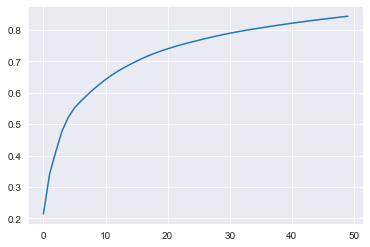

In [109]:
pca = PCA(50).fit(faces.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

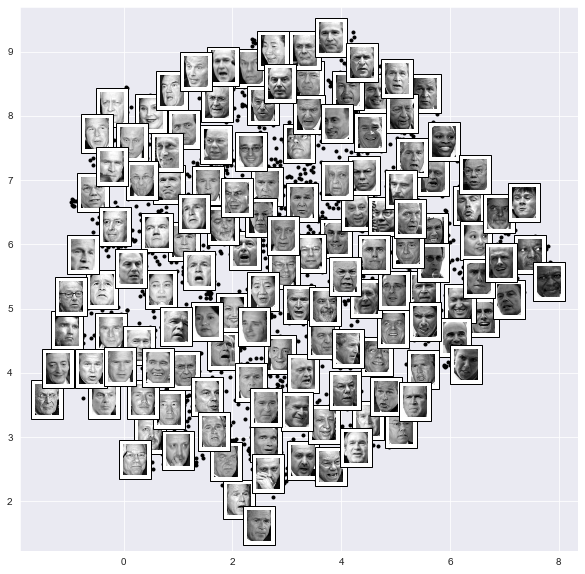

In [107]:
from sklearn.manifold import Isomap
#import umap
import umap.umap_ as umap
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 10),)
model = umap.UMAP(n_neighbors=5, n_components=2)
plot_components(faces.data, model, images=faces.images[:,::2,::2], #All images and change the shape
                ax=ax, thumb_frac=0.05)

In [ ]:
####MISC STUFF####

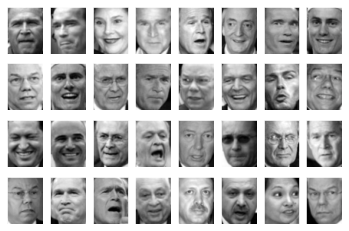

In [104]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

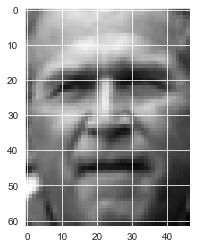

In [105]:
#for i in range(0,2370):
plt.imshow(faces.data[0].reshape(62,47),cmap='binary_r')

In [101]:
faces.data.shape

(2370, 2914)

In [92]:
faces.images[:,::2,::2].shape

(2370, 31, 24)

In [49]:
range(100)[5:18:2] #Start at 5 end at 18-1 at every 2

range(5, 18, 2)

In [ ]:
[]